In [9]:
#clean up in v02 and run tests
#v03 cleaner
#v04 moving NN's to py file

import pandas as pd
import os
from tqdm import tqdm
import time
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model, regularizers
from helper_functions.testing_functions import accuracy_distance, accuracy_moneyline, accuracy_ou
from helper_functions.simulate_game import simulate_game
from helper_functions.combine_matrices import combine_team_matrix
from tensorflow.keras.losses import Loss
import seaborn as sns
import pickle
from helper_functions import nn_architectures as nn

In [10]:
def calc_dist(x1,x2,y1,y2):
    return np.sqrt((x1-y1)**2 + (x2-y2)**2)

def calc_ou(x1,x2,y1,y2):
    return (y1+y2) - (x1+x2)

def calc_winner(x1,x2,y1,y2):
    return (x1>x2)==(y1>y2)

def calc_score(data, var='Distance'):
    if var == 'Distance':
        func = np.vectorize(calc_dist)
    elif var == 'OU':
        func=np.vectorize(calc_ou)
    elif var == 'Winner':
        func=np.vectorize(calc_winner)

    result = func(data['Real Home Score'],
                    data['Real Away Score'],
                    data['Projected Home Score'],
                    data['Projected Away Score'])
    return result

In [11]:
avg_matrix = pd.read_excel('avg_transition_matrix_with_manual_edits.xlsx', sheet_name = 'Mean Pasted', index_col='Starting_State')

In [12]:
#load game data
with open('ma_list.pickle', 'rb') as file:
    ma_list = pickle.load(file)

with open('mb_list.pickle', 'rb') as file:
    mb_list = pickle.load(file)

with open('output_list.pickle', 'rb') as file:
    output_list = pickle.load(file)

In [13]:
#going to zip these into dicts to access by game ID
game_ids = []
for game in tqdm(os.listdir('raw_game_pulls')):
    game_ids.append(game.split('_')[0])


#FINAL RAW DICTS
team_A_matrices_raw = dict(zip(game_ids, ma_list))
team_B_matrices_raw = dict(zip(game_ids, mb_list))
outputs_raw = dict(zip(game_ids, output_list))

  0%|          | 0/5498 [00:00<?, ?it/s]

100%|██████████| 5498/5498 [00:00<00:00, 2747888.87it/s]


In [14]:
#transform regular output data into argmax array form
arr_outputs = []
for x in output_list:
    value1, value2 = x

    # Create numpy arrays
    array1 = np.zeros(201)
    array2 = np.zeros(201)

    # Set the corresponding indices to 1
    array1[value1 - 1] = 1
    array2[value2 - 1] = 1 
    arr_outputs.append((array1, array2))

#FINAL ARRAY DICT
outputs_array = dict(zip(game_ids, arr_outputs))

In [15]:
#normalize inputs ###############################################################################

with open('helper_functions/avg_input_matrix.pickle', 'rb') as file:
    avg_df = pickle.load(file)

with open('helper_functions/std_input_matrix.pickle', 'rb') as file:
    std_dev_df = pickle.load(file)

norm_inputs_a = []
norm_inputs_b = []

#Normalize each value in each matrix
for matrix in ma_list:
    normalized_matrix = (matrix - avg_df) / std_dev_df
    normalized_matrix=normalized_matrix.fillna(0.)
    norm_inputs_a.append(normalized_matrix)

for matrix in mb_list:
    normalized_matrix = (matrix - avg_df) / std_dev_df
    normalized_matrix=normalized_matrix.fillna(0.)
    norm_inputs_b.append(normalized_matrix)


#NORMALIZED MATRIX DICTS
team_A_matrices_normal = dict(zip(game_ids, norm_inputs_a))
team_B_matrices_normal = dict(zip(game_ids, norm_inputs_b))

In [16]:
#load saved simulations into dicts with game ID and 1000 scores
saved_sim_ids = [x.split('.')[0] for x in os.listdir('saved_sims_small')]
simulated_scores = []
for x in  os.listdir('saved_sims_small'):
    with open('saved_sims_small/{}'.format(x), 'rb') as file:
        data=pickle.load(file)
        simulated_scores.append(data)
simulated_scores_dict = dict(zip(saved_sim_ids, simulated_scores))

In [17]:
#train test split on simulated score game IDS 
train_index, test_index = train_test_split(list(simulated_scores_dict.keys()), test_size=0.2)

In [18]:
#matrix_A_train is list of normalized input matrices used for training NN
matrix_A_train = [team_A_matrices_normal[x] for x in train_index]
matrix_B_train = [team_B_matrices_normal[x] for x in train_index]


#y_train is training list of argmax formatted outputs
y_train = [outputs_array[x] for x in train_index]

#matrix_A_test is list of normalized input matrices used for testing NN
matrix_A_test = [team_A_matrices_normal[x] for x in test_index]
matrix_B_test = [team_B_matrices_normal[x] for x in test_index]

#y_test is testing list of argmax formatted outputs
y_test=[outputs_array[x] for x in test_index]

#get testing versions of raw outputs (not for NN testing, just accuracy calcs)
final_scores_test = [outputs_raw[x] for x in test_index]

#do same as above for regular simulation testing - not normalized and no training data needed
simulation_output_test = [simulated_scores_dict[x] for x in test_index]

In [19]:
def test_nn_output(model, game_index, num_sims):
    #Pull and Convert test matrices to numpy arrays
    test_matrix_a_array = matrix_A_test[test_index.index(game_index)].values.reshape(-1, 18, 18)
    test_matrix_b_array = matrix_B_test[test_index.index(game_index)].values.reshape(-1, 18, 18)

    predictions = model.predict([test_matrix_a_array, test_matrix_b_array], verbose=0)

    home_scores = np.random.choice(np.arange(1,202), num_sims, p=predictions[0][0])
    away_scores = np.random.choice(np.arange(1,202), num_sims, p=predictions[1][0])

    current_df = pd.DataFrame(zip(home_scores, away_scores), columns = ['Home','Away'])
    current_df['Game']=game_index
    return current_df

In [20]:
#variables list

#ALL GAMES:
#team_A_matrices_raw - dict of key: game_id, val: home team matrix
#team_B_matrices_raw - dict of key: game_id, val: away team matrix
#outputs_raw - dict of key: game_id, val: final score tuple
#outputs_array - dict of key: game_id, val: array version of output (one-hot format)
#team_A_matrices_normal - dict of key: game_id, val: normalized home team matrix
#team_B_matrices_normal - dict of key: game_id, val: normalized away team matrix

#saved_sim_ids - list of game IDS in simulated data
#simulated_scores_dict - dict of key: game_id, val: list of 1000 score tuples

#train_index, test_index - lists of game id's for training and testing

#TRAINING GAMES:
#matrix_A_train - list of normalized home team matrices for training
#matrix_B_train - list of normalized away team matrices for training
#y_train - list of one-hot outputs for training

#TESTING GAMES:
#matrix_A_test - list of normalized home team matrices for testing
#matrix_B_test - list of normalized away team matrices for testing
#y_test - list of one-hot outputs for testing

#simulation_output_test - list of 1000 score tuples for testing
#final_scores_test - 

In [21]:
m1 = nn.train_model(nn.nn1, 
                    matrix_A_train, 
                    matrix_B_train, 
                    y_train, 10, 64)

In [22]:
data_list = []
for g in tqdm(range(len(final_scores_test))):
    real_score = final_scores_test[g]
    current_1000 = simulation_output_test[g]
    current_df = pd.DataFrame(current_1000, columns=['Projected Home Score','Projected Away Score'])
    current_df['Game'] = test_index[g]
    current_df['Real Home Score'] = real_score[0]
    current_df['Real Away Score'] = real_score[1]
    data_list.append(current_df)
testing_dataframe = pd.concat(data_list).reset_index(drop=True)

  0%|          | 0/1100 [00:00<?, ?it/s]

100%|██████████| 1100/1100 [00:05<00:00, 197.06it/s]


In [23]:
testing_dataframe['Distance'] = calc_score(testing_dataframe)
testing_dataframe['OU'] = calc_score(testing_dataframe, 'OU')
testing_dataframe['Winner'] = calc_score(testing_dataframe, 'Winner')
testing_df_grouped = testing_dataframe.groupby('Game')[['Distance','OU','Winner']].mean().reset_index()
testing_df_grouped['Correct'] = testing_df_grouped['Winner']>0.5

In [24]:
testing_df_grouped['Correct'].mean()

0.6709090909090909

In [25]:
m2 = nn.train_model(nn.nn1, matrix_A_train, matrix_B_train, y_train, 10, 64)

In [26]:
m3=nn.train_model(nn.nn2, matrix_A_train, matrix_B_train, y_train, 10, 64)

In [27]:
m4=nn.train_model(nn.nn3, matrix_A_train, matrix_B_train, y_train, 10, 64)

In [28]:
m5=nn.train_model(nn.nn4, matrix_A_train, matrix_B_train, y_train, 10, 64)

In [29]:
m6=nn.train_model(nn.nn5, matrix_A_train, matrix_B_train, y_train, 10, 64)

In [90]:
m7=nn.train_model(nn.nn1, matrix_A_train, matrix_B_train, y_train, 16, 12)
m8=nn.train_model(nn.nn3, matrix_A_train, matrix_B_train, y_train, 16, 12)
m9=nn.train_model(nn.nn5, matrix_A_train, matrix_B_train, y_train, 6, 128)
m10=nn.train_model(nn.nn4, matrix_A_train, matrix_B_train, y_train, 16, 8)
m11=nn.train_model(nn.nn5, matrix_A_train, matrix_B_train, y_train, 10, 95)

In [92]:
nn_list=[m1,m2, m3, m4, m5, m6, m7, m8, m9, m10, m11]

In [93]:
models_dict=dict()
models_dict['sim']=testing_df_grouped

for model_num in range(len(nn_list)):    
    current_data_list = []
    for gid in tqdm(test_index):
        real_score = final_scores_test[test_index.index(gid)]
        current_nn_test = test_nn_output(nn_list[model_num], gid, 1000)
        current_nn_test=current_nn_test.rename(columns={'Home':'Projected Home Score',
                                                    'Away':'Projected Away Score'})
        current_nn_test['Real Home Score'] = real_score[0]
        current_nn_test['Real Away Score'] = real_score[1]

        current_data_list.append(current_nn_test)

    nn_testing_dataframe = pd.concat(current_data_list)

    temp_df=nn_testing_dataframe.copy()
    temp_df=temp_df.drop(['Real Home Score','Real Away Score'], axis=1).rename(columns={'Projected Home Score':'Projected Home Score {}'.format(model_num),
                                                                                                    'Projected Away Score':'Projected Away Score {}'.format(model_num)})
    if model_num == 0:
        meta_tracker_df=temp_df.copy()
    else:
        meta_tracker_df=pd.concat([meta_tracker_df,temp_df],axis=1)


    nn_testing_dataframe['Distance'] = calc_score(nn_testing_dataframe)
    nn_testing_dataframe['OU'] = calc_score(nn_testing_dataframe, 'OU')
    nn_testing_dataframe['Winner'] = calc_score(nn_testing_dataframe, 'Winner')

    nn_testing_df_grouped = nn_testing_dataframe.groupby('Game')[['Distance','OU','Winner']].mean().reset_index()
    nn_testing_df_grouped['Correct'] = nn_testing_df_grouped['Winner']>.5
    models_dict['nn_{}'.format(model_num)]=nn_testing_df_grouped

100%|██████████| 1100/1100 [00:55<00:00, 19.69it/s]


In [94]:
meta_tracker_df.head()

,Projected Home Score 0,Projected Away Score 0,Game,Projected Home Score 1,Projected Away Score 1,Game,Projected Home Score 2,Projected Away Score 2,Game,Projected Home Score 3,...,Game,Projected Home Score 8,Projected Away Score 8,Game,Projected Home Score 9,Projected Away Score 9,Game,Projected Home Score 10,Projected Away Score 10,Game
0,79,78,6196352,69,66,6196352,86,56,6196352,73,...,6196352,93,37,6196352,86,70,6196352,72,60,6196352
1,73,82,6196352,57,66,6196352,85,71,6196352,73,...,6196352,84,78,6196352,64,76,6196352,64,72,6196352
2,79,73,6196352,94,70,6196352,51,79,6196352,90,...,6196352,92,53,6196352,57,60,6196352,82,61,6196352
3,54,89,6196352,66,86,6196352,98,60,6196352,73,...,6196352,56,105,6196352,73,81,6196352,70,90,6196352
4,94,78,6196352,69,80,6196352,74,70,6196352,73,...,6196352,79,84,6196352,68,60,6196352,61,68,6196352


In [95]:
suffixes = ['0','1','2','3','4','5','6','7','8','9', '10']

In [96]:
from itertools import combinations

In [102]:
all_bumpus = list(combinations(suffixes, 11)) + list(combinations(suffixes, 10)) + list(combinations(suffixes, 9))

In [103]:
len(all_bumpus)

67

In [104]:
# BIG_COPY = models_dict.copy()

In [105]:

meta_tracker_df.head(2)

,Projected Home Score 0,Projected Away Score 0,Game,Projected Home Score 1,Projected Away Score 1,Game,Projected Home Score 2,Projected Away Score 2,Game,Projected Home Score 3,...,Game,Projected Home Score 8,Projected Away Score 8,Game,Projected Home Score 9,Projected Away Score 9,Game,Projected Home Score 10,Projected Away Score 10,Game
0,79,78,6196352,69,66,6196352,86,56,6196352,73,...,6196352,93,37,6196352,86,70,6196352,72,60,6196352
1,73,82,6196352,57,66,6196352,85,71,6196352,73,...,6196352,84,78,6196352,64,76,6196352,64,72,6196352


In [106]:
all_bumpus[0]

('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10')

In [107]:
'err' in comb

False

In [108]:
for comb in tqdm(all_bumpus):
    df_copy=meta_tracker_df.copy()
    size=len(comb)


    df_copy['combo_home'] = (('0' in comb) * df_copy['Projected Home Score 0'] \
            + ('1' in comb) * df_copy['Projected Home Score 1'] \
                + ('2' in comb) * df_copy['Projected Home Score 2'] \
                    + ('3' in comb) * df_copy['Projected Home Score 3'] \
                    + ('4' in comb) * df_copy['Projected Home Score 4']\
        + ('5' in comb) * df_copy['Projected Home Score 5'] \
            + ('6' in comb) * df_copy['Projected Home Score 6'] \
                + ('7' in comb) * df_copy['Projected Home Score 7'] \
                    + ('8' in comb) * df_copy['Projected Home Score 8'] \
                    + ('9' in comb) * df_copy['Projected Home Score 9']\
                    + ('10' in comb) * df_copy['Projected Home Score 10'])/size

    df_copy['combo_away'] = (('0' in comb) * df_copy['Projected Away Score 0'] \
            + ('1' in comb) * df_copy['Projected Away Score 1'] \
                + ('2' in comb) * df_copy['Projected Away Score 2'] \
                    + ('3' in comb) * df_copy['Projected Away Score 3'] \
                    + ('4' in comb) * df_copy['Projected Away Score 4']\
        + ('5' in comb) * df_copy['Projected Away Score 5'] \
            + ('6' in comb) * df_copy['Projected Away Score 6'] \
                + ('7' in comb) * df_copy['Projected Away Score 7'] \
                    + ('8' in comb) * df_copy['Projected Away Score 8'] \
                    + ('9' in comb) * df_copy['Projected Away Score 9']\
                    + ('10' in comb) * df_copy['Projected Away Score 10'])/size
    
    a_list = list(np.repeat('a', 10))

    combo_1 = df_copy[['Game','combo_home','combo_away']].copy()
    cols = a_list + ['Game','Projected Home Score','Projected Away Score']
    combo_1.columns = cols
    combo_1 = combo_1.drop('a', axis=1)

    combo_1=pd.concat([combo_1, nn_testing_dataframe[['Real Home Score','Real Away Score']]], axis=1)

    combo_1['Distance'] = calc_score(combo_1)
    combo_1['OU'] = calc_score(combo_1, 'OU')
    combo_1['Winner'] = calc_score(combo_1, 'Winner')

    combo_1_grouped = combo_1.groupby('Game')[['Distance','OU','Winner']].mean().reset_index()
    combo_1_grouped['Correct'] = combo_1_grouped['Winner']>.5
    models_dict['combo_{}'.format(all_bumpus.index(comb))]=combo_1_grouped


100%|██████████| 67/67 [01:48<00:00,  1.61s/it]


In [109]:
plot_data=dict()
for var in ['Distance','OU','Winner','Correct']:
    curr_dict=dict()
    for model in models_dict.keys():
        temp_df=models_dict[model][['Game',var]]
        temp_df=temp_df.rename(columns={var:var+'_{}'.format(model)})
        curr_dict[model]=temp_df
    base_df=list(curr_dict.values())[0]
    for df in list(curr_dict.values())[1:]:
        base_df=base_df.merge(df, on='Game')
    plot_data[var]=base_df


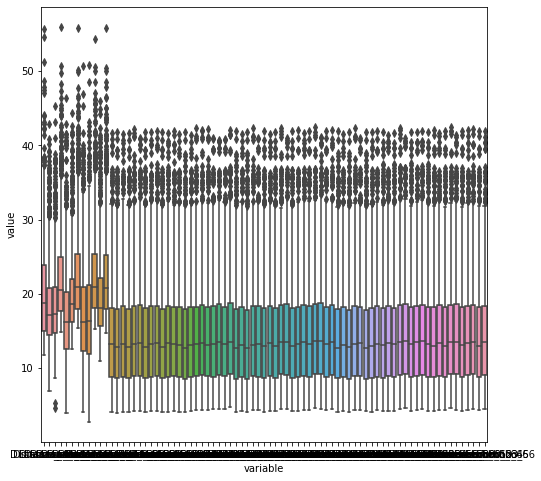

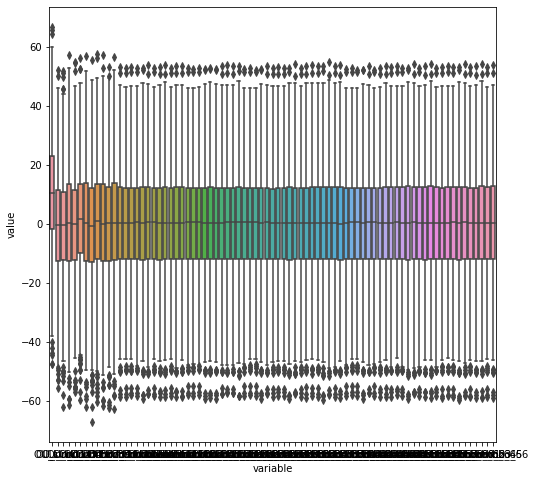

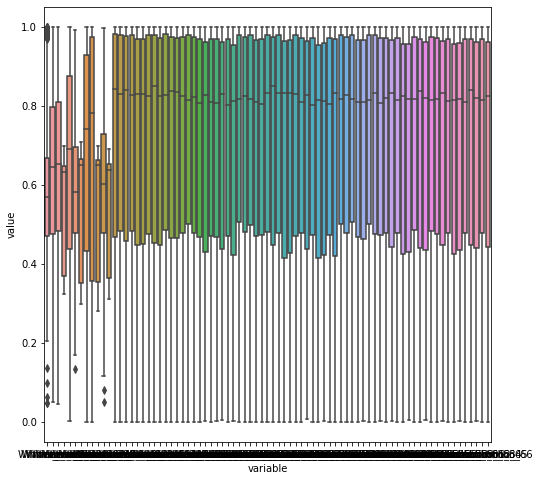

Correct_sim         0.670909
Correct_nn_0        0.723636
Correct_nn_1        0.727273
Correct_nn_2        0.680000
Correct_nn_3        0.686364
                      ...   
Correct_combo_62    0.738182
Correct_combo_63    0.716364
Correct_combo_64    0.714545
Correct_combo_65    0.739091
Correct_combo_66    0.716364
Length: 79, dtype: float64

In [110]:
for v in list(plot_data.values())[:-1]:
    fig, ax=plt.subplots(figsize=(8,8))
    to_plot=v.melt(id_vars='Game')
    sns.boxplot(x='variable',y='value',data=to_plot)
    plt.show()
winner_accuracy = list(plot_data.values())[-1]
winner_accuracy=winner_accuracy.drop('Game',axis=1).mean()
winner_accuracy

In [111]:
list(winner_accuracy)

[0.6709090909090909,
 0.7236363636363636,
 0.7272727272727273,
 0.68,
 0.6863636363636364,
 0.7036363636363636,
 0.68,
 0.7018181818181818,
 0.6827272727272727,
 0.68,
 0.7172727272727273,
 0.68,
 0.7318181818181818,
 0.74,
 0.7245454545454545,
 0.74,
 0.7181818181818181,
 0.72,
 0.7381818181818182,
 0.7263636363636363,
 0.7209090909090909,
 0.74,
 0.7227272727272728,
 0.7254545454545455,
 0.7390909090909091,
 0.7509090909090909,
 0.7381818181818182,
 0.7363636363636363,
 0.7090909090909091,
 0.7354545454545455,
 0.73,
 0.7136363636363636,
 0.7345454545454545,
 0.71,
 0.7518181818181818,
 0.74,
 0.7490909090909091,
 0.7354545454545455,
 0.7345454545454545,
 0.7390909090909091,
 0.7118181818181818,
 0.7381818181818182,
 0.7072727272727273,
 0.7109090909090909,
 0.7390909090909091,
 0.7290909090909091,
 0.7163636363636363,
 0.7336363636363636,
 0.7118181818181818,
 0.7127272727272728,
 0.7336363636363636,
 0.7181818181818181,
 0.75,
 0.74,
 0.7509090909090909,
 0.7354545454545455,
 0.731

In [114]:
list(winner_accuracy).index(np.max((list(winner_accuracy))))

34

In [121]:
winner_accuracy.sort_values()

Correct_sim         0.670909
Correct_nn_2        0.680000
Correct_nn_5        0.680000
Correct_nn_8        0.680000
Correct_nn_10       0.680000
                      ...   
Correct_combo_24    0.749091
Correct_combo_40    0.750000
Correct_combo_42    0.750909
Correct_combo_13    0.750909
Correct_combo_22    0.751818
Length: 79, dtype: float64

In [112]:
# so best combo this time was all_bumpus 22, then 13, 42, 40, 24

Correct_sim         0.670909
Correct_nn_0        0.723636
Correct_nn_1        0.727273
Correct_nn_2        0.680000
Correct_nn_3        0.686364
                      ...   
Correct_combo_62    0.738182
Correct_combo_63    0.716364
Correct_combo_64    0.714545
Correct_combo_65    0.739091
Correct_combo_66    0.716364
Length: 79, dtype: float64

In [117]:
all_bumpus[22]

('0', '1', '2', '3', '4', '6', '7', '8', '9')

In [122]:
all_bumpus[13]

('0', '1', '2', '3', '4', '5', '6', '7', '9')

In [123]:
all_bumpus[42]

('0', '1', '3', '4', '5', '6', '7', '9', '10')

In [124]:
all_bumpus[24]

('0', '1', '2', '3', '4', '6', '7', '9', '10')

In [ ]:
#conclusion on this run - 8 is bad, 10 not great. So exclude m9, m11

In [125]:
with open('models/nn_m1_319.pickle', 'wb') as handle:
    pickle.dump(m1, handle)

with open('models/nn_m2_319.pickle', 'wb') as handle:
    pickle.dump(m2, handle)

with open('models/nn_m3_319.pickle', 'wb') as handle:
    pickle.dump(m3, handle)

with open('models/nn_m4_319.pickle', 'wb') as handle:
    pickle.dump(m4, handle)

with open('models/nn_m5_319.pickle', 'wb') as handle:
    pickle.dump(m5, handle)

with open('models/nn_m6_319.pickle', 'wb') as handle:
    pickle.dump(m6, handle)

with open('models/nn_m7_319.pickle', 'wb') as handle:
    pickle.dump(m7, handle)

with open('models/nn_m8_319.pickle', 'wb') as handle:
    pickle.dump(m8, handle)

# with open('models/nn_m9_319.pickle', 'wb') as handle:
#     pickle.dump(m2, handle)

with open('models/nn_m10_319.pickle', 'wb') as handle:
    pickle.dump(m10, handle)

# with open('models/nn_m11_319.pickle', 'wb') as handle:
#     pickle.dump(m2, handle)

In [ ]:
m4, m5, m6, m7, m8, m9, m10, m11